<a href="https://colab.research.google.com/github/Stevenn9981/tic_tac_toe/blob/master/tic_tac_toe_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 338 kB in 2s (195 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the ne

In [21]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import random
import os
import shutil
import tempfile
import zipfile

import pygame as pg
from pygame import gfxdraw
from pygame.locals import *

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.specs import array_spec
from tf_agents.utils import common

tempdir = "./"

In [3]:
tf.version.VERSION

'2.14.0'

## Hyper-parameters

In [4]:
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 256  # @param {type:"integer"}
learning_rate = 3e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


BOARD_SIZE = 9 # @param {type:"integer"}

## Environment

In [5]:
import gym
from gym.spaces import Box, Discrete
import numpy as np
import math
from tabulate import tabulate

from typing import Tuple, List


class TicTacToeEnv2(gym.Env):
    """
    Implementation of a TicTacToe Environment based on OpenAI Gym standards
    This class is modified from https://github.com/MauroLuzzatto/OpenAI-Gym-TicTacToe-Environment
    I modified that to follow the instructions of Question 1.
    """

    def __init__(self, mode='rgb_array') -> None:
        """This class contains a TicTacToe environment for OpenAI Gym

        Args:
            mode (str): 'rgb_array' or 'human'
        """
        self.ener_bin_len = 0.05
        self.num_bin = int(1 / self.ener_bin_len) + 1
        self.n_actions = BOARD_SIZE * BOARD_SIZE * self.num_bin   # 9 * 9 * 21 actions
        # We discretize the energy point by splitting it into (num_bin = 21) bins. i.e., it can be [0, 0.05, 0.10,..., 1.00]
        self.action_space = gym.spaces.Discrete(self.n_actions)
        # state: 9 * 9 * 2: the first 9 * 9 layer is the opponent's play history and the second 9 * 9 layer is ours.
        self.observation_space = gym.spaces.MultiBinary([BOARD_SIZE, BOARD_SIZE, 2])
        self.render_mode = mode
        self.colors = [1, 2]
        self.screen = None
        self.fields_per_side = BOARD_SIZE
        self.reset()

    def reset(self) -> Tuple[np.ndarray, dict]:
        """
        reset the board game and state
        """
        self.board: np.ndarray = np.zeros(
            (self.fields_per_side, self.fields_per_side), dtype=int
        )
        self.current_player = 1
        self.info = {"players": {1: {"actions": [], "energy": 10}, 2: {"actions": [], "energy": 10}}, "Occupied": set()}

        if self.render_mode == 'human':
            self.render(self.render_mode)
        return self.decompose_board_to_state()

    def decompose_board_to_state(self):
        """
        Our state is a 9x9x2 matrix.
        The first layer is the opponent's play history, 0 means no stone, 1 means stones placed by the opponent.
        The second layer is the current player's history, 0 means no stone, 1 means stones placed by the current player.
        """
        opponent = 2 if self.current_player == 1 else 1
        o_plays = (self.board == opponent) * 1
        c_plays = (self.board == self.current_player) * 1
        return np.stack([o_plays, c_plays], axis=2)


    def step(self, action: tuple) -> Tuple[np.ndarray, int, bool, dict]:
        """step function of the tictactoeEnv2

        Args:
          action (tuple): the first element is an integer between [0, 80] representing a field on the board, and the second is to calculate the energy.

        Returns:
          state (np.array): state of 2 players' history, 0 means no stone, 1 means stones placed by the corresponding player (shape: 9x9x2).
          reward (int): reward of the currrent step
          done (boolean): true, if the game is finished
          (dict): empty dict for future game related information
        """

        if not self.action_space.contains(action):
            raise ValueError(f"action '{action}' is not in action_space")

        (row, col, ener) = self.decode_action(action)
        energy_to_use = ener * self.ener_bin_len

        reward = -0.1  # assign (negative) reward for every move done

        # If the agent/player does not choose an empty square, randomly select an empty one.
        if self.board[row, col] != 0:
            play_out = random.choice(list(set(range(BOARD_SIZE * BOARD_SIZE)) - self.info["Occupied"]))
            row, col, energy_to_use = self.decode_action(play_out)
            reward -= 0.3 # assign a negative reward if the play out position is not empty

        # Check whether there is enough energy to use for the current player
        if self.info["players"][self.current_player]["energy"] < energy_to_use:
            energy_to_use = self.info["players"][self.current_player]["energy"]

        # randomly select an adjacent position with probability 1/16
        if random.random() < (1 - 1 / 9 - 6 / 9 * energy_to_use):
            adjs = [[-1, -1], [-1, 0], [-1, 1], [0, 1], [0, -1], [1, -1], [1, 0], [1, 1]]
            adj = random.choice(adjs)
            row, col = row + adj[0], col + adj[1]

        if 0 <= row < BOARD_SIZE and 0 <= col < BOARD_SIZE and self.board[row, col] == 0:
            self.board[row, col] = self.current_player  # postion the token on the field
            self.info["players"][self.current_player]["energy"] -= energy_to_use
            win = self._is_win(self.current_player, row, col)

            play_out = row * BOARD_SIZE + col
            self.info["players"][self.current_player]["actions"].append(play_out)
            self.info["Occupied"].add(play_out)
        else:
            win = False

        if win:
            reward += 3

        done = (win or len(self.info["Occupied"]) == BOARD_SIZE * BOARD_SIZE)
        self.current_player = self.current_player + 1 if self.current_player == 1 else 1
        state = self.decompose_board_to_state()
        return state, reward, done, self.info

    def _is_win(self, color: int, r: int, c: int) -> bool:
        """check if this player results in a winner

        Args:
            color (int): of the player
            r (int): row of the current play
            c (int): column of the current play

        Returns:
            bool: indicating if there is a winner
        """

        # check if four equal stones are aligned (horizontal, verical or diagonal)
        directions = [[0, 1], [1, 0], [1, 1], [1, -1]]

        for direct in directions:
            count = 0
            for offset in range(-3, 4):
                if 0 <= r + offset * direct[0] < 9 and 0 <= c + offset * direct[1] < 9:
                    if self.board[r + offset * direct[0], c + offset * direct[1]] == color:
                        count += 1
                        if count == 4:
                            return True
                    else:
                        count = 0

        return False

    def decode_action(self, action: int) -> List[int]:
        """decode the action integer into a column and row value, and energy

        0 = upper left corner
        8 = lower right corner

        Args:
            action (int): action

        Returns:
            List[int, int]: a list with the [row, col] values
        """
        action = np.clip(action, 0, self.n_actions)

        num_places = BOARD_SIZE * BOARD_SIZE

        board_position = action % num_places
        energy = action // num_places

        col = board_position % BOARD_SIZE
        row = board_position // BOARD_SIZE
        assert 0 <= col < BOARD_SIZE
        assert 0 <= row < BOARD_SIZE
        assert 0 <= energy < self.num_bin
        return [row, col, energy]

    def render(self, mode="human") -> None:
        """render the board

        The following charachters are used to represent the fields,
            '-' no stone
            'O' for player 0
            'X' for player 1

        An example for a 3x3 game board:
            ╒═══╤═══╤═══╕
            │ O │ - │ - │
            ├───┼───┼───┤
            │ - │ X │ - │
            ├───┼───┼───┤
            │ - │ - │ - │
            ╘═══╧═══╧═══╛
        """
        board = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=str)
        for ii in range(BOARD_SIZE):
            for jj in range(BOARD_SIZE):
                if self.board[ii, jj] == 0:
                    board[ii, jj] = "-"
                elif self.board[ii, jj] == 1:
                    board[ii, jj] = "X"
                elif self.board[ii, jj] == 2:
                    board[ii, jj] = "O"

        if mode == "human":
            board = tabulate(board, tablefmt="fancy_grid")
            print(board)
            print("\n")


        width = height = 400

        white = (255, 255, 255)
        line_color = (0, 0, 0)

        os.environ["SDL_VIDEODRIVER"] = "dummy"
        pg.init()

        # Set up the drawing window
        if self.screen is None:
          self.screen = pg.display.set_mode([width + 160, height + 16])

        self.screen.fill(white)
        # drawing vertical lines
        for i in range(10):
          pg.draw.line(self.screen, line_color, (width / BOARD_SIZE * i, 0), (width / BOARD_SIZE * i, height), 2)

        # drawing horizontal lines
        for i in range(10):
          pg.draw.line(self.screen, line_color, (0, height / BOARD_SIZE * i), (width, height / BOARD_SIZE * i), 2)
        pg.display.flip()

        # drawing noughts and crosses
        for i in range(BOARD_SIZE):
          for j in range(BOARD_SIZE):
            if self.board[i, j] == 1: # Draw crosses
              pg.draw.lines(self.screen, line_color, True, [(width / BOARD_SIZE * (j + 0.5) - 10,
                                                        height / BOARD_SIZE * (i + 0.5) - 10),
                                                      (width / BOARD_SIZE * (j + 0.5) + 10,
                                                        height / BOARD_SIZE * (i + 0.5) + 10)], 3)
              pg.draw.lines(self.screen, line_color, True, [(width / BOARD_SIZE * (j + 0.5) - 10,
                                                        height / BOARD_SIZE * (i + 0.5) + 10),
                                                        (width / BOARD_SIZE * (j + 0.5) + 10,
                                                          height / BOARD_SIZE * (i + 0.5) - 10)], 3)
            elif self.board[i, j] == 2: # Draw noughts
              pg.draw.circle(self.screen, line_color, (width / BOARD_SIZE * (j + 0.5), height / BOARD_SIZE * (i + 0.5)), 12, 3)

        # drawing the next energy points of two players

        font1 = pg.font.Font(pg.font.get_default_font(), 16)
        font2 = pg.font.Font(pg.font.get_default_font(), 14)

        # now print the text
        text_surface1 = font1.render('Energy Points:', True, pg.Color('black'))
        text_surface2 = font2.render(f'Player 1: {self.info["players"][1]["energy"]:.2f}', True, pg.Color('black'))
        text_surface3 = font2.render(f'Player 2: {self.info["players"][2]["energy"]:.2f}', True, pg.Color('black'))
        self.screen.blit(text_surface1, dest=(width + 15, 0))
        self.screen.blit(text_surface2, dest=(width + 15, 22))
        self.screen.blit(text_surface3, dest=(width + 15, 42))

        board = np.transpose(
                np.array(pg.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

        return board

## Random play test

In [6]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="480" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, fps=2):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
      time_step = tf_env.reset()
      video.append_data(py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = tf_env.step(action_step.action)
        video.append_data(py_env.render())

    return embed_mp4(filename)

In [7]:
py_env = suite_gym.wrap_env(TicTacToeEnv2())
tf_env = tf_py_environment.TFPyEnvironment(py_env)

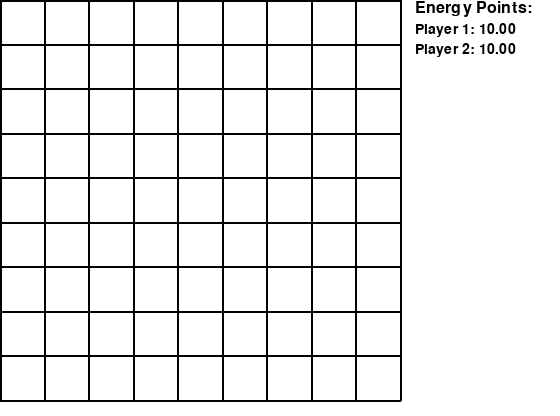

In [8]:
py_env.reset()
PIL.Image.fromarray(py_env.render())

In [9]:
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
create_policy_eval_video(random_policy, "random-agent")

## Agent

In [10]:
train_py_env = suite_gym.wrap_env(TicTacToeEnv2())
eval_py_env = suite_gym.wrap_env(TicTacToeEnv2())

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:
conv_layer_params = [16, 32]
action_tensor_spec = tensor_spec.from_spec(tf_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Conv layers configured with the right
# activation and kernel initializer.
def conv_layer(num_units):
  return tf.keras.layers.Conv2D(
                      filters=num_units,
                      kernel_size=[3, 3],
                      padding="same",
                      data_format="channels_last",
                      activation=tf.nn.leaky_relu,
                      dtype=float)


# QNetwork consists of a sequence of Conv layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
normalization1 = tf.keras.layers.BatchNormalization()
normalization2 = tf.keras.layers.BatchNormalization()
conv_layers = [conv_layer(num_units) for num_units in conv_layer_params]
action_conv = tf.keras.layers.Conv2D(filters=4,
                    kernel_size=[1, 1], padding="same",
                    data_format="channels_last",
                    activation=tf.nn.leaky_relu)
flatten = tf.keras.layers.Flatten()
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential([normalization1] + conv_layers + [action_conv, normalization2, flatten, q_values_layer])

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policy

In [13]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

In [14]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [15]:
compute_avg_return(eval_env, agent.policy, 1)

-5.2000003

## Replay Buffer

In [16]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

## Set up the checkpointer and Policy saver

In [25]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [26]:
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

## Train the agent

In [ ]:
try:
  %%time
except:
  pass

py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      tf_policy_saver.save(policy_dir)
      policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))
      returns.append(avg_return)

step = 200: loss = 366969.3125
step = 400: loss = 4387303.0
step = 600: loss = 2617199.25
step = 800: loss = 2872436.0
step = 1000: loss = 3514309.0
step = 1000: Average Return = -16.309993743896484


/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


step = 1200: loss = 7110533.5
step = 1400: loss = 5184992.0
step = 1600: loss = 4707011.0
step = 1800: loss = 8446632.0
step = 2000: loss = 358811008.0
step = 2000: Average Return = -17.569988250732422


/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


## Load the trained policy

In [24]:
saved_policy = tf.saved_model.load(policy_dir)
create_policy_eval_video(saved_policy, "trained-agent")

## TODO



*   Check whether the `is_winner` function is correct
*   Check whether the environment is correctly implement
*   Add the variant in `step` function
*   Test whether the agent always chooses an *empty* square and whether they can go to an adjacent place correctly

